# Table of Contents<a id="Top"></a>

1. [Problem Statement](#1)<br>
2. [Sensitivity Analysis](#5)<br>
    2.1 [TUC - BOS](#5.2)<br>

# 1. Problem Statement<a id=1></a>

In this problem, we will consider a sensitivity analysis related to Tucson to Boston. Specifically, let's examine how changes in the cost per unit coefficient changes certain aspects of this optimization problem. This will be similar to the work that we did in class related to the Tucson to Atlanta route.

If you have the figure `problem.png` in the same folder as this .ipynb, you can see the picture that uses this code: `![Table of Data](problem.png)`

![Table of Data](problem.png)

##### [Back to Top](#Top)

# 2. Data<a id=2></a>

In [1]:
import pandas as pd 
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

### Read and convert data

In [2]:
xlsx_file = pd.ExcelFile('w05-c02-transportation.xlsx')
xlsx_file.sheet_names

['Sensitivity Report 1', 'Transportation', 'coef', 'rhs']

Show the tab and shift-tab tricks. 

In [3]:
cost = pd.read_excel(xlsx_file, sheet_name = 'coef', index_col = 0)
cost

,ATL,BOS,CHI,DEN
MIN,0.60,0.56,0.22,0.40
PIT,0.36,0.30,0.28,0.58
TUC,0.65,0.68,0.55,0.42


In [4]:
demand = pd.read_excel(xlsx_file, sheet_name = 'rhs', index_col = 0, usecols = [0,1])
capacity = pd.read_excel(xlsx_file, sheet_name = 'rhs', index_col = 0, 
                         usecols = [3,4], nrows = 3)

In [5]:
demand

,Requirement
Warehouse,
ATL,8000
BOS,10000
CHI,12000
DEN,9000


In [6]:
capacity

,Capacity
Plant,
MIN,10000
PIT,15000
TUC,15000


##### [Back to Top](#Top)

# 3. Model Definition<a id=3><a>

In [7]:
model = pe.ConcreteModel()

### Define Decision Variables

We will create three plant variables with individual indexes for the four warehouses. 

In [8]:
DV_indexes = ['ATL', 'BOS', 'CHI', 'DEN']
model.MIN = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
model.PIT = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
model.TUC = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
model.pprint()

3 Set Declarations
    MIN_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'ATL', 'BOS', 'CHI', 'DEN'}
    PIT_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'ATL', 'BOS', 'CHI', 'DEN'}
    TUC_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'ATL', 'BOS', 'CHI', 'DEN'}

3 Var Declarations
    MIN : Size=4, Index=MIN_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
        ATL :     0 :  None :  None : False :  True : NonNegativeReals
        BOS :     0 :  None :  None : False :  True : NonNegativeReals
        CHI :     0 :  None :  None : False :  True : NonNegativeReals
        DEN :     0 :  None :  None : False :  True : NonNegativeReals
    PIT : Size=4, Index=PIT_index
        Key : Lower : Value : Upper : Fix

### Define Objective Function

Here we need to create a formula for all 12 decision variables. We loop through the warehouse indexes for each plant.

In [9]:
model.obj = pe.Objective(expr = sum([cost.loc['MIN', index]*model.MIN[index] for index in DV_indexes] +
                         [cost.loc['PIT', index]*model.PIT[index] for index in DV_indexes] +
                         [cost.loc['TUC', index]*model.TUC[index] for index in DV_indexes]),
                         sense = pe.minimize)

In [10]:
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.6*MIN[ATL] + 0.56*MIN[BOS] + 0.22*MIN[CHI] + 0.4*MIN[DEN] + 0.36*PIT[ATL] + 0.3*PIT[BOS] + 0.28*PIT[CHI] + 0.58*PIT[DEN] + 0.65*TUC[ATL] + 0.68*TUC[BOS] + 0.55*TUC[CHI] + 0.42*TUC[DEN]


### Define Constraints

We finish defining the model by defining both the capacity and demand constraints.

In [11]:
#Capacity Constraints
model.con_MIN = pe.Constraint(expr = sum(model.MIN[index] for index in DV_indexes) 
                              <= capacity.loc['MIN','Capacity'])
model.con_PIT = pe.Constraint(expr = sum(model.PIT[index] for index in DV_indexes)
                              <= capacity.loc['PIT','Capacity'])
model.con_TUC = pe.Constraint(expr = sum(model.TUC[index] for index in DV_indexes)
                              <= capacity.loc['TUC','Capacity'])   
#Demand Constraints
model.con_ATL = pe.Constraint(expr = model.MIN['ATL'] + model.PIT['ATL']+ 
                              model.TUC['ATL'] >= demand.loc['ATL','Requirement'])
model.con_BOS = pe.Constraint(expr = model.MIN['BOS'] + model.PIT['BOS']+ 
                              model.TUC['BOS'] >= demand.loc['BOS','Requirement'])
model.con_CHI = pe.Constraint(expr = model.MIN['CHI'] + model.PIT['CHI']+ 
                              model.TUC['CHI'] >= demand.loc['CHI','Requirement'])
model.con_DEN = pe.Constraint(expr = model.MIN['DEN'] + model.PIT['DEN']+ 
                              model.TUC['DEN'] >= demand.loc['DEN','Requirement'])

In [12]:
model.con_MIN.pprint()

con_MIN : Size=1, Index=None, Active=True
    Key  : Lower : Body                                      : Upper   : Active
    None :  -Inf : MIN[ATL] + MIN[BOS] + MIN[CHI] + MIN[DEN] : 10000.0 :   True


##### [Back to Top](#Top)

# 4. Model Solution<a id=4></a>

In [13]:
opt = pe.SolverFactory('glpk')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


And here we show the final values for the model shown in the constraints as `Body`.
Note we can see the final values for our demand and capacity constraints. All of our lhs values are at the bounds so are binding constraints except for capacity constraint 3 which had a final value of 14,000 but the capacity is 15,000 so it had a slack of 1,000 units.

In [14]:
model.display()

Model unknown

  Variables:
    MIN : Size=4, Index=MIN_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
        ATL :     0 :     0.0 :  None : False : False : NonNegativeReals
        BOS :     0 :     0.0 :  None : False : False : NonNegativeReals
        CHI :     0 : 10000.0 :  None : False : False : NonNegativeReals
        DEN :     0 :     0.0 :  None : False : False : NonNegativeReals
    PIT : Size=4, Index=PIT_index
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
        ATL :     0 :  5000.0 :  None : False : False : NonNegativeReals
        BOS :     0 : 10000.0 :  None : False : False : NonNegativeReals
        CHI :     0 :     0.0 :  None : False : False : NonNegativeReals
        DEN :     0 :     0.0 :  None : False : False : NonNegativeReals
    TUC : Size=4, Index=TUC_index
        Key : Lower : Value  : Upper : Fixed : Stale : Domain
        ATL :     0 : 3000.0 :  None : False : False : NonNegativeReals
        BOS :     0 :    0

The above shows us all the information all at once. Let's pull out the optimal minimum cost and the final value of the decision variables.

#### Optimal Objective Value

In [15]:
obj_val = model.obj.expr()
print(f'optimal objective value minimum cost = ${obj_val:.2f}')

optimal objective value minimum cost = $13830.00


#### Optimal Decision Variables

In order to capture the results, we have to use new code to reference the 3 variable names - `model.component_objects(pe.Var)` and each set of indexes. We can use looping to pull out the values. 

In [16]:
for DV in model.component_objects(pe.Var):
    print(DV)
    for var in DV:
        print(" ", var, DV[var].value)

MIN
  ATL 0.0
  BOS 0.0
  CHI 10000.0
  DEN 0.0
PIT
  ATL 5000.0
  BOS 10000.0
  CHI 0.0
  DEN 0.0
TUC
  ATL 3000.0
  BOS 0.0
  CHI 2000.0
  DEN 9000.0


Let's do create a `pd.DataFrame` to store the results of our solution. 

In [17]:
DV_solution = pd.DataFrame()
for DV in model.component_objects(pe.Var):
    for var in DV:
        DV_solution.loc[DV.name, var] = DV[var].value
DV_solution

,ATL,BOS,CHI,DEN
MIN,0.0,0.0,10000.0,0.0
PIT,5000.0,10000.0,0.0,0.0
TUC,3000.0,0.0,2000.0,9000.0


Here we create a plot of the Decision Variables solution.

# 5. Sensitivity Analysis<a id=5></a>

Define a new function `run_model()` to obtain values.

In [18]:
def run_model():
    #Function to run the model 
    
    #This just runs the model as we defined it above
    model = pe.ConcreteModel()
    #Decision Variables
    DV_indexes = ['ATL','BOS','CHI','DEN']
    model.MIN = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
    model.PIT = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
    model.TUC = pe.Var(DV_indexes, domain = pe.NonNegativeReals)
    #Objective Function
    model.obj = pe.Objective(expr = sum([cost.loc['MIN', index]*model.MIN[index] for index in DV_indexes] +
                             [cost.loc['PIT', index]*model.PIT[index] for index in DV_indexes] +
                             [cost.loc['TUC', index]*model.TUC[index] for index in DV_indexes]),
                             sense = pe.minimize)
    #Capacity Constraints
    model.con_MIN = pe.Constraint(expr = sum(model.MIN[index] for index in DV_indexes) 
                                  <= capacity.loc['MIN','Capacity'])
    model.con_PIT = pe.Constraint(expr = sum(model.PIT[index] for index in DV_indexes)
                                  <= capacity.loc['PIT','Capacity'])
    model.con_TUC = pe.Constraint(expr = sum(model.TUC[index] for index in DV_indexes)
                                  <= capacity.loc['TUC','Capacity'])   
    #Demand Constraints
    model.con_ATL = pe.Constraint(expr = model.MIN['ATL'] + model.PIT['ATL']+ 
                                  model.TUC['ATL'] >= demand.loc['ATL','Requirement'])
    model.con_BOS = pe.Constraint(expr = model.MIN['BOS'] + model.PIT['BOS']+ 
                                  model.TUC['BOS'] >= demand.loc['BOS','Requirement'])
    model.con_CHI = pe.Constraint(expr = model.MIN['CHI'] + model.PIT['CHI']+ 
                                  model.TUC['CHI'] >= demand.loc['CHI','Requirement'])
    model.con_DEN = pe.Constraint(expr = model.MIN['DEN'] + model.PIT['DEN']+ 
                                  model.TUC['DEN'] >= demand.loc['DEN','Requirement'])
    opt = pe.SolverFactory('glpk')
    opt.solve(model, tee=False) #solve model and supress output
    
    #Once we solve the model we return the model object so we can get the optimal obj function value
    return model

## 5.1 TUC-BOS<a id=5.1></a>

Here is the original cost table just to remind us.

In [19]:
cost

,ATL,BOS,CHI,DEN
MIN,0.60,0.56,0.22,0.40
PIT,0.36,0.30,0.28,0.58
TUC,0.65,0.68,0.55,0.42


First we'll loop through all the costs from shipping from Tucson to Boston, re-solve the model, and capture the objective function optimal values. Create a sequence from 0.5 to 0.7 in increments of 0.1.

In [20]:
tuc_bos_costs = [(i + 50)/100 for i in list(range(0, 21))]
tuc_bos_costs

[0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7]

In [21]:
obj_list_tb = []
for val in tuc_bos_costs:
    #This single line updates the cost table
    cost.loc['TUC', 'BOS'] = val
    #This reruns the model using our function
    model = run_model()
    obj_list_tb.append(model.obj.expr())
obj_list_tb

[13420.0,
 13470.0,
 13520.0,
 13570.0,
 13620.0,
 13670.0,
 13720.0,
 13770.0,
 13800.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0,
 13830.0]

Let's make it look nicer and easier to see what is going on by storing the results in a dataframe changing the index to be the costs.

In [22]:
obj_df_tb = pd.DataFrame(obj_list_tb, 
                         index = tuc_bos_costs, 
                         columns = ['cost'])
obj_df_tb

,cost
0.50,13420.0
0.51,13470.0
0.52,13520.0
0.53,13570.0
0.54,13620.0
0.55,13670.0
0.56,13720.0
0.57,13770.0
0.58,13800.0
0.59,13830.0


Plot the results using Seaborn

In [23]:
zip_list = list(zip(tuc_bos_costs, obj_list_tb))
zip_list

[(0.5, 13420.0),
 (0.51, 13470.0),
 (0.52, 13520.0),
 (0.53, 13570.0),
 (0.54, 13620.0),
 (0.55, 13670.0),
 (0.56, 13720.0),
 (0.57, 13770.0),
 (0.58, 13800.0),
 (0.59, 13830.0),
 (0.6, 13830.0),
 (0.61, 13830.0),
 (0.62, 13830.0),
 (0.63, 13830.0),
 (0.64, 13830.0),
 (0.65, 13830.0),
 (0.66, 13830.0),
 (0.67, 13830.0),
 (0.68, 13830.0),
 (0.69, 13830.0),
 (0.7, 13830.0)]

In [24]:
df = pd.DataFrame(zip_list, columns = ['TUC2BOS', 'Cost'])
df

,TUC2BOS,Cost
0,0.50,13420.0
1,0.51,13470.0
2,0.52,13520.0
3,0.53,13570.0
4,0.54,13620.0
5,0.55,13670.0
6,0.56,13720.0
7,0.57,13770.0
8,0.58,13800.0
9,0.59,13830.0


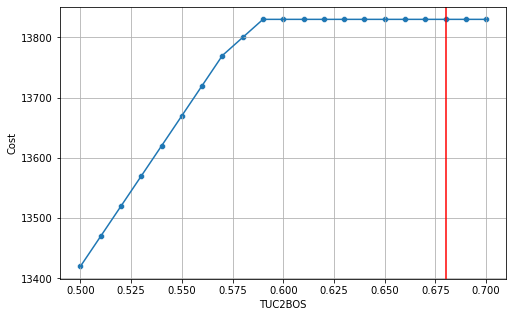

In [25]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = 'TUC2BOS', y = 'Cost', data = df)
sns.lineplot(x = 'TUC2BOS', y = 'Cost', data = df)
plt.grid()
plt.axvline(x = .68, color = "red")
plt.show()

# Create the line plots

So what about the Decision variables? There are 12 for each model solution, we need to capture them a slightly different way. We'll put each solution in a list and then make a list of lists.

In [26]:
DV_list_tb=[]
for val in tuc_bos_costs:
    DV_curr_list_tb = []
    #This single line updates the cost table
    cost.loc['TUC', 'BOS'] = val
    #This reruns the model using our function
    model = run_model()
    for DV in model.component_objects(pe.Var):
        for c in DV:
            DV_curr_list_tb.append(DV[c].value)
    DV_list_tb.append(DV_curr_list_tb)
print(DV_list_tb)

[[0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 5000.0, 2000.0, 0.0, 0.0, 5000.0, 0.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 7000.0, 0.0, 0.0, 0.0, 3000.0, 2000.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 8000.0, 7000.0, 0.0, 0.0, 0.0, 3000.0, 2000.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2000.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 5000.0, 10000.0, 0.0, 0.0, 3000.0, 0.0, 2000.0, 9000.0], [0.0, 0.0, 10000.0, 0.0, 

Again, let's format this so it is easy to read.

In [27]:
DV_col_names=['M,A','M,B','M,C','M,D','P,A','P,B','P,C','P,D', 'T,A','T,B','T,C','T,D']
DV_df_tb = pd.DataFrame(DV_list_tb,
                        columns = DV_col_names)
DV_df_tb['Costs'] = tuc_bos_costs
DV_df_tb

,"M,A","M,B","M,C","M,D","P,A","P,B","P,C","P,D","T,A","T,B","T,C","T,D",Costs
0,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.50
1,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.51
2,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.52
3,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.53
4,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.54
5,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.55
6,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.56
7,0.0,0.0,10000.0,0.0,8000.0,5000.0,2000.0,0.0,0.0,5000.0,0.0,9000.0,0.57
8,0.0,0.0,10000.0,0.0,8000.0,7000.0,0.0,0.0,0.0,3000.0,2000.0,9000.0,0.58
9,0.0,0.0,10000.0,0.0,8000.0,7000.0,0.0,0.0,0.0,3000.0,2000.0,9000.0,0.59


We'll finish looking at this data by creating a line plot to monitor the changes in the optimal DV over the different Tucson-Boston cost changes. So - this kinda works but we have too
many decision variables it is hard to follow the colors.

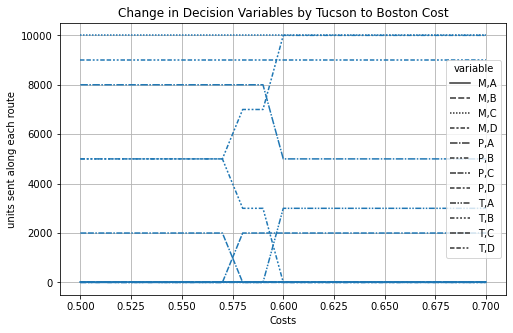

In [28]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Costs', y = 'value', style = 'variable', data = pd.melt(DV_df_tb, 'Costs'))
plt.grid()
plt.title('Change in Decision Variables by Tucson to Boston Cost')
plt.ylabel('units sent along each route')
plt.show()

For our final version, let's create a plot for each Plant's Decision Variables. Remember we stored the Plant,Warehouse pairs for the Decision Variables in the list `DV_col_names`. I will pull out just the ones that are needed for the specific Plant. For example, here we see the Tucson pairs.

In [29]:
print(DV_col_names)
DV_col_names[8:12]

['M,A', 'M,B', 'M,C', 'M,D', 'P,A', 'P,B', 'P,C', 'P,D', 'T,A', 'T,B', 'T,C', 'T,D']


['T,A', 'T,B', 'T,C', 'T,D']

In [30]:
df = pd.melt(DV_df_tb, 'Costs')
df

,Costs,variable,value
0,0.50,"M,A",0.0
1,0.51,"M,A",0.0
2,0.52,"M,A",0.0
3,0.53,"M,A",0.0
4,0.54,"M,A",0.0
...,...,...,...
247,0.66,"T,D",9000.0
248,0.67,"T,D",9000.0
249,0.68,"T,D",9000.0
250,0.69,"T,D",9000.0


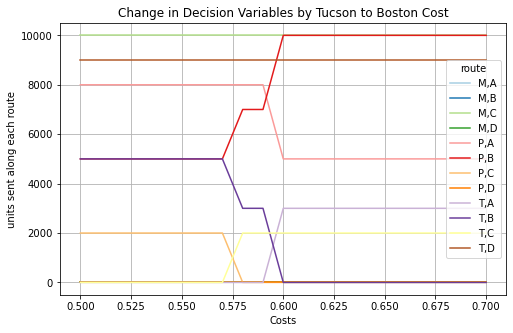

In [31]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Costs', y = 'value', hue = 'variable', palette = sns.color_palette("Paired"),
             data = df)
plt.grid()
plt.title('Change in Decision Variables by Tucson to Boston Cost')
plt.ylabel('units sent along each route')
plt.legend(title = "route")
plt.show()

In [32]:
df['plants'] = df['variable'].str[:1]
df

,Costs,variable,value,plants
0,0.50,"M,A",0.0,M
1,0.51,"M,A",0.0,M
2,0.52,"M,A",0.0,M
3,0.53,"M,A",0.0,M
4,0.54,"M,A",0.0,M
...,...,...,...,...
247,0.66,"T,D",9000.0,T
248,0.67,"T,D",9000.0,T
249,0.68,"T,D",9000.0,T
250,0.69,"T,D",9000.0,T


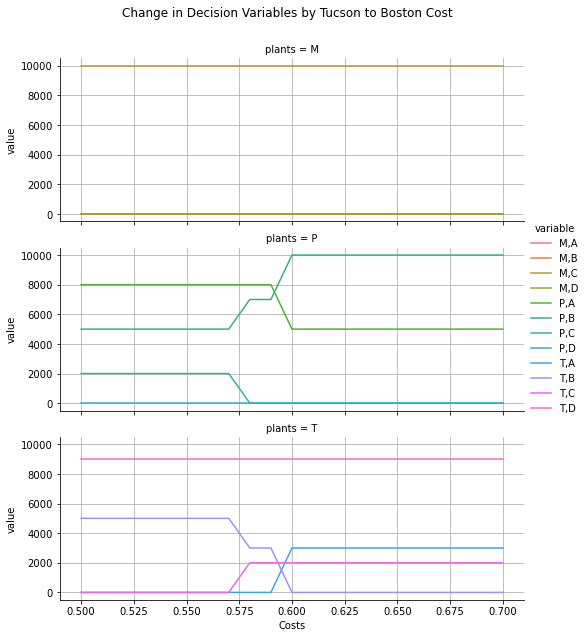

In [33]:
sns.set_style({'axes.grid' : True,'axes.edgecolor':'black'})
facet_plot = sns.FacetGrid(data = df, row = 'plants', hue = 'variable', height = 3, aspect = 2.5)
facet_plot.map(sns.lineplot, 'Costs', 'value').add_legend()
facet_plot.fig.subplots_adjust(top = 0.9)
facet_plot.fig.suptitle('Change in Decision Variables by Tucson to Boston Cost')
plt.show()